## Dimensionality reduction: Hydrogen mechanism (H2_Li)

### Step 1: Zero-dimensional simulation

In [1]:
## Dimensionality reduction: Hydrogen mechanism (H2_Li)

### Step 1: Zero-dimensional simulationimport sys
import numpy as np
import cantera as ct
import matplotlib.pylab as plt

gas = ct.Solution('/Users/aditya/work/projects/isml/jupyter/mech/H2_Li/H2_Li.cti')

# simulation parameters
nstep = 2500
dtime = 1.e-7

# composition
gas.TPY = 1120.0, ct.one_atm*1.2, 'H2:0.00811,O2:0.18316,H2O:0.05182,N2:0.75692'
r = ct.IdealGasConstPressureReactor(gas)

# data matrix (size NTxNV)
nt = nstep+1
nx = nt
nsc = gas.Y.size
nv = nsc + 1
X = np.zeros((nt,nv)) # data matrix
p = np.zeros((nt))


# simulation object
sim = ct.ReactorNet([r])
time = np.zeros(nt)

# initial condition
for i in range(nsc):
    X[0,i] = gas.Y[i]
X[0,nv-1] = gas.T
p[0] = gas.P


for n in range(nstep):
    time[n+1]=time[n]+dtime
    # integrates the solution in time
    sim.advance(time[n+1])
    # append data to X matrix
    for i in range(nsc):
        X[n+1,i] = gas.Y[i]
    X[n+1,nv-1] = gas.T
    p[n+1] = gas.P
    
    


ModuleNotFoundError: No module named 'cantera'

#### Compute reaction rate

In [2]:
nRR = gas.n_reactions        # number of reactions
RR = np.zeros((nt,nRR))   # reaction rates matrix


# print reactions
# for ir in range(nRR):
#     print(gas.reactions()[ir])

# compute reaction rates at each time step
for it in range(nt):
    gas.TP = X[it,nv-1],p[it]
    gas.Y = X[it,:nsc]
    for ir in range(nRR):
        RR[it,ir] = gas.net_rates_of_progress[ir]



In [3]:
# plot reaction rates
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (8,6)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True 

# plt.figure()
# plt.plot(time*1e3, RR[:,0], '-r')
# plt.plot(time*1e3, RR[:,1], '-g')
# plt.plot(time*1e3, RR[:,2], '-b')
# plt.plot(time*1e3, RR[:,3], '-k')
# plt.xlabel('Time (ms)')
# plt.ylabel('Reaction rate');

### Step 2: Compute principal values and vectors

#### Scaling data matrix

In [4]:
def scaleData(nf, v):

    # compute mean
    v_mean = np.mean(v, axis=0)
#     print(v_mean)
    v_max = np.max(np.abs(v), axis=0)
#     print(v_max)

    # add for loop to scale the data: NORMALIZATION
    for i in range(nf):
        v[:, i] = (v[:, i] - v_mean[i])/v_max[i]
#         v[:, i] = (v[:, i])/v_max[i]

    return None

Xs = np.zeros((nx,nv)) # scaled data matrix
Xs = np.copy(X)

scaleData(nv,Xs)
# print(Xs)

#### Co-variance matrix

In [5]:
def covar(u):
    mom = np.zeros((nv, nv), dtype=float, order='F')
    # compute covariance matrix
    for j in range(nv):
        for i in range(nv):
            for n in range(nx):
                mom[i,j] = mom[i,j] + u[n,i] * u[n,j]                
    mom = mom/nx    
#     mom=np.true_divide(mom, nx)
#     print(mom)
    return mom

mom2 = np.zeros((nv, nv), dtype=float, order='F')
mom2 = covar(Xs)
print(mom2)

[[ 2.08343051e-01  7.73371609e-02 -6.07307689e-02 -1.52130075e-01
  -1.18634285e-01 -2.02884105e-02  2.53235943e-02 -6.17107478e-02
  -2.64768341e-29 -7.48996568e-02]
 [ 7.73371609e-02  2.87359354e-02 -2.33116933e-02 -5.71360139e-02
  -4.39983405e-02 -7.89539807e-03  9.34065734e-03 -2.37125125e-02
   9.90239652e-30 -2.77168265e-02]
 [-6.07307689e-02 -2.33116933e-02  5.85189731e-02  6.89686461e-02
   3.18450509e-02  4.24270199e-02  1.12436087e-02  6.10023880e-02
  -1.11090288e-30  1.57143873e-02]
 [-1.52130075e-01 -5.71360139e-02  6.89686461e-02  1.29810460e-01
   8.51062669e-02  3.26188036e-02 -9.80746287e-03  7.13332455e-02
   4.82108825e-30  5.13542879e-02]
 [-1.18634285e-01 -4.39983405e-02  3.18450509e-02  8.51062669e-02
   6.77506572e-02  8.78028072e-03 -1.60868098e-02  3.22226341e-02
   3.06148054e-29  4.30902477e-02]
 [-2.02884105e-02 -7.89539807e-03  4.24270199e-02  3.26188036e-02
   8.78028072e-03  4.24457317e-02  2.26028280e-02  4.48834883e-02
  -2.07371692e-30  1.10105967e-03

#### Co-kurtosis tensor (matricized)

In [6]:
def cokurt(u):
    tmp = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
    # compute cokurtosis matrix
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    for n in range(nx):
                        tmp[i,j,k,l] = tmp[i,j,k,l] + u[n,i] * u[n,j] * u[n,k] * u[n,l]
    
    tmp=tmp/nx
    return tmp


mom4_t = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
mom4_t = cokurt(Xs)

In [7]:
mom4 = np.reshape(mom4_t,(nv,nv*nv*nv),order='F')
# print(mom4)

#### Cumulant Excess-kurtosis tensor (matricized)

In [8]:
def excesskurt(u):
    tmp = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
    # compute cokurtosis matrix
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    for n in range(nx):
                        tmp[i,j,k,l] = tmp[i,j,k,l] + u[n,i] * u[n,j] * u[n,k] * u[n,l]    
    
    tmp=tmp/nx
    
    for l in range(nv):
        for k in range(nv):
            for j in range(nv):
                for i in range(nv):
                    tmp[i,j,k,l] = tmp[i,j,k,l] - mom2[i,j]*mom2[k,l] - mom2[i,k]*mom2[j,l] - mom2[i,l]*mom2[j,k]
                    
    return tmp


mom42_t = np.zeros((nv,nv,nv,nv), dtype=float, order='F')
mom42_t = excesskurt(Xs)

In [9]:
mom42 = np.reshape(mom42_t,(nv,nv*nv*nv),order='F')
# print(mom42)

#### Principal values and vectors

In [10]:
# factorize co-variance matrix: SVD of the covariance matrix
U2, S2, V2 = np.linalg.svd(mom2)

# factorize co-kurtosis tensor
U4, S4, V4 = np.linalg.svd(mom4)

# factorize excess-kurtosis tensor
U42, S42, V42 = np.linalg.svd(mom42)

### Step 3: write data

#### Save simulation data

In [17]:
# write mass fractions, temperature and pressure
with open('YTP_H2_Li.npy', 'wb') as fid:
    np.save(fid, X)
    np.save(fid, p)
    np.save(fid, RR)
    
# with open('YTP_H2_Li.npy', 'rb') as fid1:    
#     xx=np.load(fid1)
#     p=np.load(fid1)

In [12]:
# principal values and principal vectors

# second moment
with open('PV2_H2_Li.npy', 'wb') as fid2:
    np.save(fid2, S2)
    np.save(fid2, U2)

# raw fourth moment
with open('PV4_H2_Li.npy', 'wb') as fid4:
    np.save(fid4, S4)
    np.save(fid4, U4)

# cumulant kurtosis moment
with open('PV42_H2_Li.npy', 'wb') as fid42:
    np.save(fid42, S42)
    np.save(fid42, U42)

#### Analyze principal values and vectors

In [13]:
S2

array([5.07467661e-01, 1.36763511e-01, 4.14087013e-02, 7.89197613e-03,
       6.18416176e-04, 7.75357510e-05, 1.24521417e-09, 6.42072612e-17,
       2.55488515e-17, 4.15679670e-28])

In [14]:
S42

array([4.17445833e-01, 8.57624542e-02, 4.19845897e-02, 9.19474360e-03,
       3.98418179e-03, 3.34678663e-04, 2.64483513e-06, 8.46442276e-16,
       4.12051088e-16, 2.07629870e-16])

In [15]:
S4

array([3.97505011e-01, 1.45591864e-01, 6.93739357e-02, 1.33052741e-02,
       2.38090190e-03, 4.06151531e-04, 2.54894078e-06, 9.55625237e-16,
       4.61094289e-16, 1.73621200e-16])

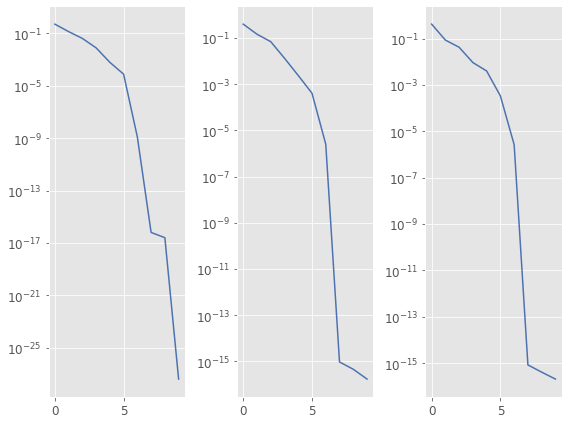

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
f1=ax1.plot(S2)
ax1.set_yscale('log')

f1=ax2.plot(S4)
ax2.set_yscale('log')

f1=ax3.plot(S42)
ax3.set_yscale('log')

In [1]:
S2=[5.07467661e-01, 1.36763511e-01, 4.14087013e-02, 7.89197613e-03,
       6.18416176e-04, 7.75357510e-05, 1.24521417e-09, 6.42072612e-17,
       2.55488515e-17, 4.15679670e-28]

In [2]:
S42=[4.17445833e-01, 8.57624542e-02, 4.19845897e-02, 9.19474360e-03,
       3.98418179e-03, 3.34678663e-04, 2.64483513e-06, 8.46442276e-16,
       4.12051088e-16, 2.07629870e-16]

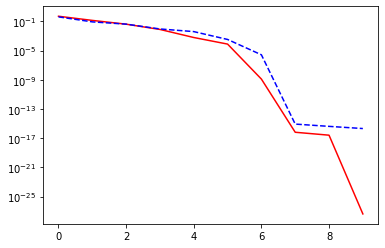

In [3]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(S2,'r')
plt.plot(S42,'b--')